# **Handai Coffee – Sales & Demand Analysis**

This analysis reveals clear demand concentration by time and product, offering actionable recommendations for operational optimization.


## **Business Objective**

The objective of this analysis is to:
- Understand sales patterns across time, products, and packaging
- Identify key demand drivers
- Provide data-driven insights to support operational and product decisions


## **Dataset Overview**
- Total records: ~5,000 transactions  
- Time period: 2024–2025  
- Granularity: Transaction-level sales data  

**Key columns:**
- transaction_date, transaction_time  
- product_name, product_category  
- packaging_type, packaging_size  
- quantity, channel, event_name


# **Data Preparation**

This section covers data cleaning, standardization, and feature engineering to ensure analytical accuracy.

### Data Quality Notes
- Some transaction dates contained incorrect year values (2026) due to data entry errors and were corrected to 2025 based on business context.
- Quantity values were standardized to numeric format prior to aggregation.
- Transaction time values were used only for hour-level analysis to avoid introducing artificial dates.

In [6]:
# Data Analysis Libraries
import pandas as pd
import matplotlib.pyplot as plt

# Display settings
pd.set_option('display.max_columns', None)

In [ ]:
df = pd.read_csv("/content/Handai Coffee Data - CLEAN SALES (2).csv")

In [8]:
df['transaction_date'] = df['transaction_date'].astype(str).str.replace(' ', '')

In [9]:
df['transaction_date'] = pd.to_datetime(
    df['transaction_date'],
    dayfirst=True,
    format='mixed',
    errors='coerce'
)

In [10]:
df['transaction_date'].isna().sum()

np.int64(0)

In [11]:
df['transaction_time'] = pd.to_datetime(
    df['transaction_time'],
    format='mixed',
    errors='coerce'
)

In [12]:
df['hour'] = df['transaction_time'].dt.hour

In [13]:
df['weekday'] = df['transaction_date'].dt.day_name()

In [14]:
df['is_weekend'] = df['weekday'].isin(['Saturday', 'Sunday'])

In [15]:
df['year_month'] = df['transaction_date'].dt.to_period('M').astype(str)

In [16]:
df['quantity'] = (
    df['quantity']
    .astype(str)
    .str.replace(',', '')   # untuk hapus koma ribuan
    .str.strip()            # untuk hapus spasi kiri-kanan
)

In [17]:
df['quantity'] = pd.to_numeric(df['quantity'], errors='coerce')

In [18]:
df['quantity'].isna().sum()

np.int64(8)

In [19]:
df.loc[
    df['transaction_date'].dt.year == 2026,
    'transaction_date'
] = df.loc[
    df['transaction_date'].dt.year == 2026,
    'transaction_date'
].apply(lambda x: x.replace(year=2025))

### Data Quality Adjustment
Some transaction dates were recorded with an incorrect year (2026) due to data entry errors.  
Based on business context and dataset coverage, these records were corrected to 2025 while preserving the original month and day values.


In [20]:
df['packaging_size'] = df['packaging_size'].astype(str)

In [22]:
df['packaging_size'] = df['packaging_size'].replace({
    'Cupml': 'Cup',
    '1l': '1000ml'
})

In [23]:
df.loc[df['packaging_size'] == 'nan', 'packaging_size'] = 'Cup'

### Packaging Size Normalization

Packaging sizes were standardized to ensure consistency. Missing values were treated as Cup, and inconsistent formats (e.g., 1L, Cupml) were normalized.

# **Exploratory Data Analysis – Time-Based Analysis**
This section analyzes sales distribution based on transaction hour to identify peak sales periods.

In [24]:
hourly_sales = (
    df
    .groupby('hour')['quantity']
    .sum()
    .reset_index()
    .sort_values('hour')
)


In [ ]:
hourly_sales

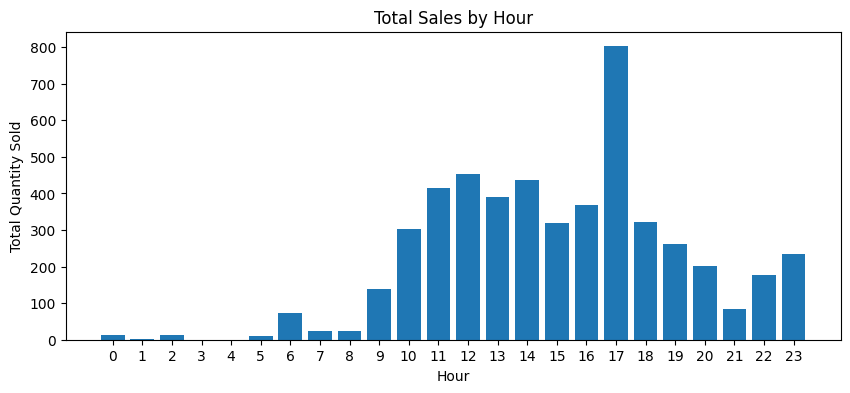

In [26]:
plt.figure(figsize=(10,4))
plt.bar(hourly_sales['hour'], hourly_sales['quantity'])
plt.xticks(range(0,24))
plt.title("Total Sales by Hour")
plt.xlabel("Hour")
plt.ylabel("Total Quantity Sold")
plt.show()


### **Insight – Hourly Sales Pattern**
- Sales activity is minimal during early morning hours (00:00–08:00).
- Sales accelerate from 09:00 onward, peaking at 17:00, indicating strong late-afternoon demand likely driven by post-work or post-class consumption.
- The highest sales volume occurs at **17:00**, indicating strong after-work or after-class demand.
- Sales remain relatively strong during evening hours (18:00–23:00), suggesting potential for extended operational hours.



# **Exploratory Data Analysis – Weekday vs Weekend**
This section compares sales performance between weekdays and weekends to understand differences in customer behavior.

In [27]:
weekend_sales = (
    df
    .groupby('is_weekend')['quantity']
    .sum()
    .reset_index()
)

weekend_sales

,is_weekend,quantity
0,False,5789.0
1,True,4147.0


In [28]:
weekend_sales['day_type'] = weekend_sales['is_weekend'].map({
    False: 'Weekday',
    True: 'Weekend'
})

weekend_sales

,is_weekend,quantity,day_type
0,False,5789.0,Weekday
1,True,4147.0,Weekend


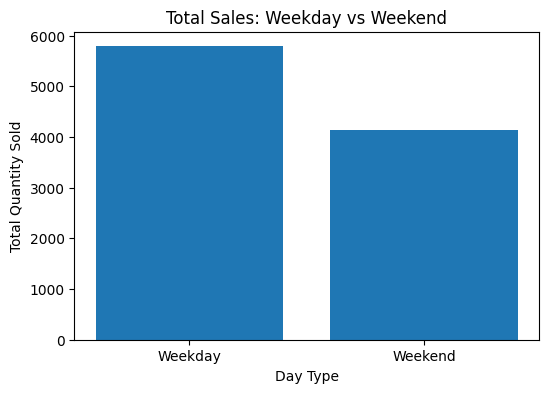

In [29]:
plt.figure(figsize=(6,4))
plt.bar(
    weekend_sales['day_type'],
    weekend_sales['quantity']
)
plt.title("Total Sales: Weekday vs Weekend")
plt.xlabel("Day Type")
plt.ylabel("Total Quantity Sold")
plt.show()

In [30]:
daily_avg = (
    df
    .groupby(['is_weekend', 'transaction_date'])['quantity']
    .sum()
    .reset_index()
    .groupby('is_weekend')['quantity']
    .mean()
    .reset_index()
)

daily_avg['day_type'] = daily_avg['is_weekend'].map({
    False: 'Weekday',
    True: 'Weekend'
})

daily_avg

,is_weekend,quantity,day_type
0,False,35.515337,Weekday
1,True,53.166667,Weekend


### **Insight – Weekday vs Weekend Sales**
- Total sales volume is higher on weekdays, largely due to a greater number of operating days.
- Despite fewer days, weekends still contribute a significant portion of total sales.
- This suggests higher per-day sales intensity during weekends, indicating strong concentrated demand.
- Weekend average daily sales (53.16) exceed weekday average (36.29), confirming higher per-day intensity.


# **Exploratory Data Analysis – Monthly Sales Trend**
This section analyzes monthly sales performance to identify trends and seasonality patterns.


In [ ]:
monthly_sales = (
    df
    .groupby('year_month')['quantity']
    .sum()
    .reset_index()
    .sort_values('year_month')
)

monthly_sales

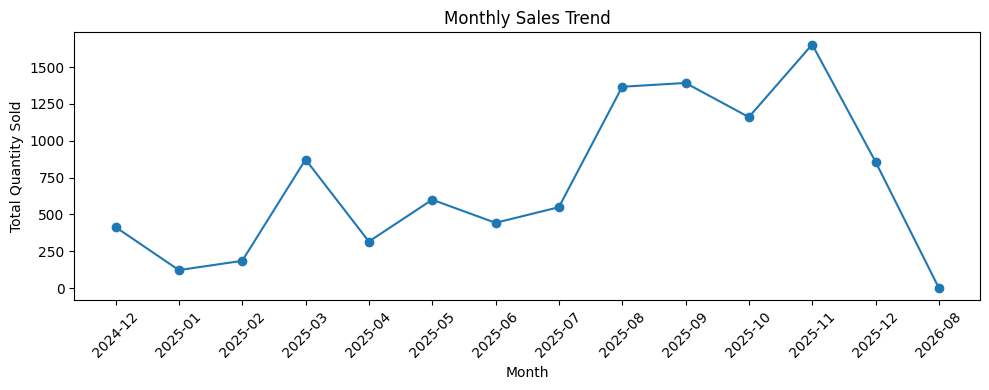

In [32]:
plt.figure(figsize=(10,4))
plt.plot(
    monthly_sales['year_month'],
    monthly_sales['quantity'],
    marker='o'
)
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Quantity Sold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### **Insight – Monthly Sales Trend**

- Sales volume shows an overall upward trend toward the second half of the year.
- Peak sales are observed in **November**, indicating strong demand during late-year periods.
- Sales fluctuate in the early months, suggesting potential seasonality or varying event intensity.
- The sharp increase in Q3–Q4 suggests event-driven demand or seasonal uplift.

# **Exploratory Data Analysis – Product & Packaging**
This section analyzes product-level performance and packaging preferences to identify key sales drivers.


In [33]:
df[['product_name', 'product_category', 'packaging_type', 'packaging_size']].head()

,product_name,product_category,packaging_type,packaging_size
0,Matcha Latte,non_coffee,botol,250ml
1,Matcha Latte,non_coffee,cup,Cup
2,Susu Kurma,non_coffee,cup,Cup
3,Matcha Latte,non_coffee,cup,Cup
4,Susu Kurma,non_coffee,cup,Cup


In [34]:
product_sales = (
    df
    .groupby('product_name')['quantity']
    .sum()
    .reset_index()
    .sort_values('quantity', ascending=False)
)

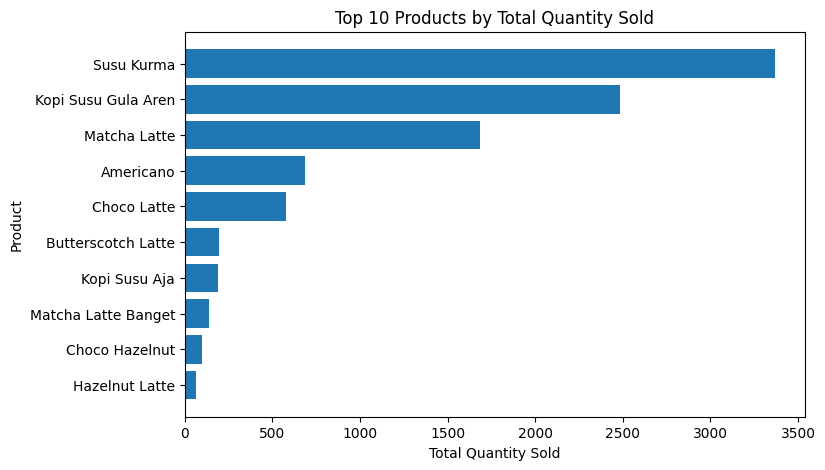

In [35]:
top10 = product_sales.head(10)

plt.figure(figsize=(8,5))
plt.barh(top10['product_name'], top10['quantity'])
plt.gca().invert_yaxis()
plt.title("Top 10 Products by Total Quantity Sold")
plt.xlabel("Total Quantity Sold")
plt.ylabel("Product")
plt.show()


### **Insight – Top Products Performance**

- Sales volume is highly concentrated in a small number of products.
- **Susu Kurma** and **Kopi Susu Gula Aren** dominate total sales, acting as core revenue drivers.
- There is a significant drop in sales volume beyond the top three products, indicating a long-tail product distribution.
- This concentration suggests that business performance is strongly dependent on a limited set of key menu items.

- Core products should be prioritized in terms of inventory availability, quality consistency, and promotion.
- Lower-performing products may benefit from bundling strategies or limited-time promotions rather than standalone focus.


In [ ]:
size_sales = (
    df
    .groupby('packaging_size')['quantity']
    .sum()
    .reset_index()
    .sort_values('quantity', ascending=False)
)

size_sales

In [37]:
main_sizes = size_sales[
    size_sales['packaging_size'].isin(['Cup', '250ml', '500ml', '1000ml'])
]

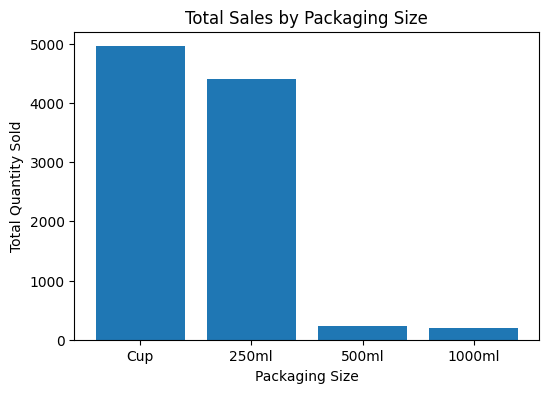

In [38]:
plt.figure(figsize=(6,4))
plt.bar(
    main_sizes['packaging_size'],
    main_sizes['quantity']
)
plt.title("Total Sales by Packaging Size")
plt.xlabel("Packaging Size")
plt.ylabel("Total Quantity Sold")
plt.show()


### **Insight – Packaging Size Preference**
- **Cup** dominates total sales volume, indicating that most purchases are made for immediate, single-serve consumption.
- Among bottled options, **250ml** is the most preferred size, significantly outperforming larger bottle sizes.
- Larger bottle sizes (500ml and 1000ml) contribute relatively small portions of total sales, suggesting more niche or situational demand.


# **Key Insights & Business Implications**

1. **Strong Time-Based Demand Concentration**  
   Sales activity is highly dependent on time, with minimal demand during early morning hours and a clear peak in the late afternoon.  
   The highest sales volume occurs around **17:00**, indicating strong after-work or after-class demand.

2. **Weekday Dominance with Concentrated Weekend Demand**  
   While weekdays contribute more to total sales volume due to a higher number of operating days, weekends still show substantial demand.  
   This suggests higher sales intensity per day during weekends, highlighting opportunities for targeted weekend strategies.

3. **Clear Late-Year Sales Growth Pattern**  
   Monthly sales demonstrate an upward trend toward the second half of the year, with **peak performance in November**.  
   This pattern suggests seasonality, potentially driven by increased events or customer activity toward year-end.

4. **High Dependence on Core Products**  
   Sales volume is highly concentrated in a small number of products, led by **Susu Kurma** and **Kopi Susu Gula Aren**.  
   Beyond the top three products, sales decline sharply, indicating a long-tail product distribution.

5. **Actionable Operational and Product Implications**  
   These findings suggest several strategic actions:
   - Prioritize core products for inventory planning and quality consistency  
   - Align staffing and operational focus with evening peak hours  
   - Leverage weekends and late-year periods for targeted promotions or campaigns


# **Conclusion & Next Steps**

This analysis highlights clear demand concentration by time and product, with strong reliance on core menu items and late-day sales periods.

**Potential next steps:**
- Deeper analysis by sales channel and event type
- Customer-level analysis if customer identifiers become available
- Integration with cost data to analyze profitability


# **Executive Summary**
* Peak sales occur at 17:00, indicating late-day demand concentration.
* Weekend sales show higher daily intensity despite fewer operating days.
* Sales trend upward in Q3–Q4, with November as peak month.
* Revenue is highly dependent on a small set of core products.
* Operational focus should prioritize evening staffing and core inventory planning.


